To Adapt Russell's code for making nice event displays and examine some of my own data that way! note: this worked for the old data, and the nans are actually fine, but he has updated his code now so I'm gonna make a new (week10) notebook to try it the new way!)

In [1]:
# python
import numpy as np
import time as t

# physics
import uproot as ur
import awkward as ak
import vector as vec

# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

In [3]:
#helper function definitions:

def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def find_index_1D(_values, _unsorted):
    ''' This function is a vectorized helper function to return the 1D locations of elements in a 
    larger unsorted list (i.e. cell geo locations). It does this by repeating/tiling arrays so they
    have equal shape and then simply comparing where the elements are equal and returning a slice
    where the indices match.
    Inputs: 
        _values: the values for which to search for the locations of in _unsorted
        _unsorted: the larger un-sorted list of elements to match
    Returns:
        _locs: locations of _values in _unsorted respectively. '''
    _shape = (len(_values), len(_unsorted))
    _values_2d = np.repeat(_values, repeats=len(_unsorted)).reshape(_shape)
    _unsorted_2d = np.tile(_unsorted, reps=len(_values)).reshape(_shape)
    
    _idx_vec = np.argwhere(np.asarray(_values_2d == _unsorted_2d))
    return _idx_vec[:,1]

def to_xyz(_coords):
    ''' Simple geometric conversion to xyz from eta, phi, rperp (READ: in this order)
    There is an elegant way to generalize this to be flexible for 1d or 2d, for now 2d
    Inputs: np array of shape (N, 3) where columns are [eta, phi, rPerp]
    Outputs: np array of shape (N, 3) where columns are [x,y,z] '''
    _eta = _coords[:,0]
    _phi = _coords[:,1]
    _rperp = _coords[:,2]
    _theta = 2*np.arctan( np.exp(-_eta) )
    
    cell_x = _rperp*np.cos(_phi)
    cell_y = _rperp*np.sin(_phi)
    cell_z = _rperp/np.tan(_theta)
    
    return np.column_stack([cell_x,cell_y,cell_z])

In [4]:
data_path = '/fast_scratch/atlas_images/v01-45/'
pi0 = ur.open(data_path+'pipm_small.root')
pi0.keys()

['EventTree;1', 'CellGeo;1']

In [5]:
event_tree = pi0['EventTree']
geo_tree = pi0['CellGeo']

In [6]:
event_dict = dict_from_event_tree(event_tree, event_branches)
track_dict = dict_from_tree_branches(event_tree, track_branches)
geo_dict = dict_from_tree_branches_np(geo_tree, geo_branches)

In [7]:
#try loading the geo tree separately?
geo_file = ur.open('/fast_scratch/atlas_images/v01-45/cell_geo.root')

CellGeo_tree = geo_file["CellGeo"]
# CellGeo_tree = my_event['CellGeo']

CellGeo_tree.show(interpretation_width=60)
geo_dict = dict_from_tree_branches_np(CellGeo_tree, geo_branches)

name                 | typename                 | interpretation                                              
---------------------+--------------------------+-------------------------------------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_sigma       | std::vector<float> 

In [8]:
len(event_dict)

17

In [18]:
#pre-select the useful events:

# create ordered list of events to use for index slicing
nEvents = len(event_dict['eventNumber'])
all_events = np.arange(0,nEvents,1,dtype=np.int32)

# SINGLE TRACK CUT
single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
filtered_event = all_events[single_track_mask]
print('Single Track Indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Single Track Indices, shape (97242,)
[ 0  1  2  3  4  5  7  8  9 12 13 14 16 17 20 21 23 24 25 26]


In [26]:
#and do eta selection on them:
trackEta_EMB1 = ak.flatten(track_dict['trackEta_EMB1'][filtered_event]).to_numpy()

central_track_mask = np.abs(trackEta_EMB1) < .7

filtered_event = filtered_event[central_track_mask]

# Save this for processing track only files later
central_single_tracks = filtered_event
print('Central track indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Central track indices, shape (30820,)
[  1   2   3   4   5   7  12  16  24  38  39  40  42  70  92  97 107 116
 124 137]


In [28]:
#select single track
nCluster = event_dict['nCluster'][filtered_event]
filtered_event_mask = nCluster != 0
filtered_event = filtered_event[filtered_event_mask]

print('Tracks with clusters, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Tracks with clusters, shape (26708,)
[  1   2   3   4   5   7  12  16  24  38  40  42  70  92  97 107 116 124
 137 155]


In [162]:
event = 155

In [163]:
#this cell doesn't seem to work for all events - event zero didn't work but event 4 did???
ak_cluster_cell_ID = event_dict['cluster_cell_ID'][event]
cell_geo_ID = geo_dict['cell_geo_ID']

nClust = len(ak_cluster_cell_ID)

clusters = []
for j in range(nClust):
    
    # find cluster size
    _nInClust = len(ak_cluster_cell_ID[j])

    # make empty array of cluster info
    _cluster = np.zeros((_nInClust, 5))
    
    # index matching
    _indices = find_index_1D(ak_cluster_cell_ID[j].to_numpy(), cell_geo_ID)

    _cluster[:,0] = geo_dict["cell_geo_eta"][_indices]
    _cluster[:,1] = geo_dict["cell_geo_phi"][_indices]
    _cluster[:,2] = geo_dict["cell_geo_rPerp"][_indices]
    _cluster[:,3] = event_dict["cluster_cell_E"][event][j].to_numpy()
    _cluster[:,4] = geo_dict["cell_geo_sampling"][_indices]
    
    clusters.append(_cluster)

In [164]:
len(geo_dict["cell_geo_eta"][_indices])

9

In [165]:
clusters

[array([[-3.49999994e-01,  4.90873866e-02,  2.45000000e+03,
          8.39157639e+01,  1.20000000e+01],
        [-3.49999994e-01, -4.90872115e-02,  2.45000000e+03,
          1.73631895e+00,  1.20000000e+01],
        [-3.49999994e-01,  1.47262156e-01,  2.45000000e+03,
          4.12272692e+00,  1.20000000e+01],
        [-4.50000018e-01,  4.90873866e-02,  2.45000000e+03,
          3.33716422e-01,  1.20000000e+01],
        [-2.50000000e-01,  4.90873866e-02,  2.45000000e+03,
          5.25050020e+00,  1.20000000e+01],
        [-4.50000018e-01, -4.90872115e-02,  2.45000000e+03,
          6.94387108e-02,  1.20000000e+01],
        [-2.50000000e-01, -4.90872115e-02,  2.45000000e+03,
          3.49834710e-01,  1.20000000e+01],
        [-4.50000018e-01,  1.47262156e-01,  2.45000000e+03,
          6.59381896e-02,  1.20000000e+01],
        [-2.50000000e-01,  1.47262156e-01,  2.45000000e+03,
          5.38392603e-01,  1.20000000e+01],
        [-2.50000000e-01,  4.90873866e-02,  3.02000000e+03,
    

In [166]:
n_tracks = event_dict['nTrack'][event]
print(n_tracks)

all_clusters = np.ndarray.copy(clusters[0])
for i in range(1,len(clusters)):
    all_clusters = np.vstack((all_clusters, clusters[i]))

1


In [167]:
layer_rPerp = []
layer_filter = [1,2,3,12,13,14]

for _layer in layer_filter:
    _mask = all_clusters[:,4] == _layer
    _rPerp_layer = all_clusters[_mask,2]
    layer_rPerp.append(np.mean(_rPerp_layer)) #good: 3, 5, 7, 16, 40, 97, 107, 155
np.array(layer_rPerp)
print(np.round(layer_rPerp,2)) #nans: 1, 2, 4, 12, 24, 38, 42, 70, 92, 116, 124, 137

[1542.74 1757.79 1944.32 2450.   3020.   3630.  ]


In [42]:
tracks = np.zeros(12)
i = 0
for _key in track_branches:
    tracks[i] = track_dict[_key][event][0]
    i += 1
tracks = np.reshape(tracks, (6,2))
tracks = np.column_stack((tracks,layer_rPerp))

In [43]:
#data conversion?

cluster_xyz = []
for i in range(len(clusters)):
    _xyz = to_xyz(clusters[i][:,0:3])
    cluster_xyz.append(_xyz)

In [44]:
tracks_xyz = to_xyz(tracks)

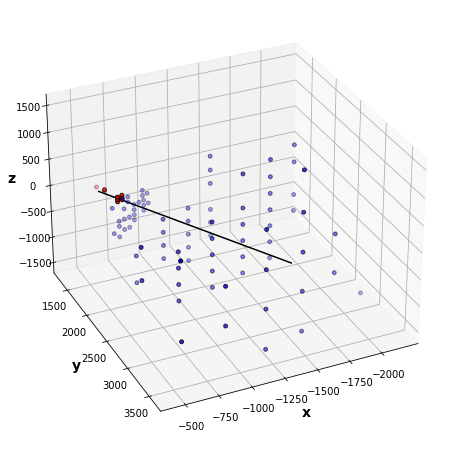

In [46]:
# keep making this bigger as the events go on
colors = ['blue', 'red', 'gold', 'darkturquoise', 'indigo', 'crimson', 'orange']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=65)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0],cluster_xyz[i][:,1],cluster_xyz[i][:,2],color=colors[i],s=15,edgecolor='black')
ax.plot(tracks_xyz[:,0], tracks_xyz[:,1], tracks_xyz[:,2], color='black')
#ax.set_xlim(-500,-3000)
#ax.set_ylim(-3000,-500)
#ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
plt.show()

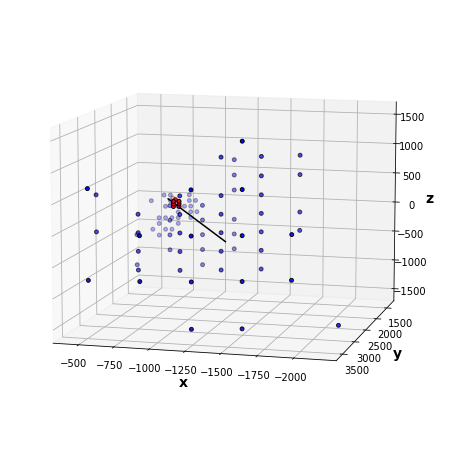

In [47]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=105)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
ax.plot(tracks_xyz[:,0], tracks_xyz[:,1], tracks_xyz[:,2], color='black')
#ax.set_xlim(-1000,-3000)
#ax.set_ylim(-3000,-750)
#ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev10_azim105_wTrack_evt22_2021-06-01.png', format='png')
plt.show()